In [1]:
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # graphs
import seaborn as sns; sns.set()   # pretty visualisations

# load the dataset
df = pd.read_csv('../input/creditcard.csv')

In [2]:
# manual paramaters
TEST_RATIO = 0.2
RANDOM_SEED = 777

In [3]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# The business problem
A perfect model automatically captures all the fraud and flags none of the clean transactions, with no costs incurred.
This is obviously utopic, and the exercise is one of **finding the optimal minimum and intersect between two cost functions**: 

1. the **cost of fraud**
    * = false negative (type II error)
    * cost of reimbursement or cost of insurance premiums protecting you against uncaught fraud cases
    * we will not consider intangibles like reputational loss
2. the **cost of human labour** for investigating the flagged transactions
    * = false positive (type I error)
    * employee(s) salary 
    * guesstimates will have to be made as to how many transactions an employee could realistically investigate

In [4]:
label_counts = df.label.value_counts()
clean, fraud = label_counts[0], label_counts[1]
total = len(df)
fraud_perc = round(fraud / total * 100, 3)

print(label_counts)
print(f'Fraud represents {fraud_perc}% of the total dataset')

0    284315
1       492
Name: label, dtype: int64
Fraud represents 0.173% of the total dataset


# Accuracy vs. Precision & Recall
When dealing with unbalanced datasets like this, choosing the correct performance metric is important.
Koo Ping Shung wrote an [excellent blog post](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) on the topic. 

Essentially, rather than aiming for overall accuracy on the entire dataset, we care more about catching most of the fraud cases (**recall**), whilst keeping the cost at which this is achieved under control (**precision**). Usually, this is captured in the **f1 score**. However, **asymmetrical costs for type I and II errors** complicate the matters and mean we have to rely on our own cost function.

What's for certain is that we can reject accuracy as a measure. Consider this: **simply classifying everything as not-fraud would yield 99.83% accuracy on this dataset**, but it would completely defeat the point.

# The cost per misclassified transaction
Let's take a look at our data and the dataset's description so we can determine what weight to attribute to each type of error.

(We assume the amount is in the same currency, say EUR)

      amount                      
      median        mean       max
label                             
0      22.00   88.291022  25691.16
1       9.25  122.211321   2125.87


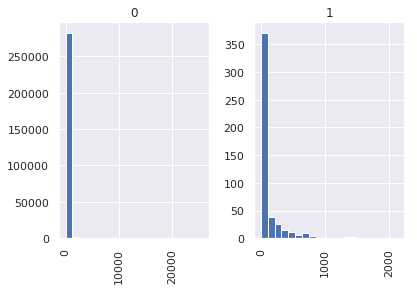

In [5]:
# distribution of amounts by label
print(df.groupby('label').agg({'amount': ['median', 'mean', 'max']}))
df.amount.hist(by=df.label, bins=20);

As is usually the case with monetary amounts, the distribution is extremely skewed with a long tail. <br>
Similar things happen when analysing salaries, for example. <br> 
An alternative is to take the log values, instead, and return the (usually) normally distributed equivalent.

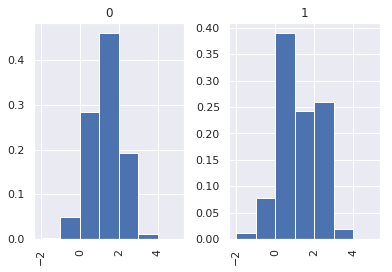

In [6]:
# add calculated field
""" Add a negligible amount to avoid a RuntimeWarning: divide by zero encountered in log10 """
df['log10_amount'] = np.log10(df.amount + 0.00001)

# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']]
    + ['log10_amount', 'label']
]

# plot distribution 
df.log10_amount.hist(by=df.label, bins=7, range=(-2,5), density=True);

Although the most common fraud attempts seem to be on tiny amounts, we see a more even distribution. 
Fraudsters seem to try and steal higher amounts on average. 

When determining the weight for our type I and II errors, we have to keep the dataset's description in mind:
> The datasets contains transactions made by credit cards in September 2013 by european cardholders. <br>
> This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

We make the following assumptions:

* **representativeness of the dataset**
    * the extract is only two days' worth of transactions, and it's all we have, so we have to simply assume that it is an accurate representation of "business as usual"
    * in other words, we assume that the average fraud cost we calculated is not some (low) outlier, compared to data covering larger time spans 
* **cost of fraud**
    * the average accounts for the occasional, worst-case scenario outlier better than the median, and is thus our measure of choice to determine the cost of Type II errors
* **cost of monitoring**
    * we assume no low-wage outsourcing, and expect this type of oversight/monitoring activity would most likely be done from a European financial hub
      (e.g. London, Brussels, Amsterdam, Paris, Dublin, Luxembourg, Frankfurt)
    * take the average gross pay in 2013 across these cities' respective countries
    * a company capable of implementing machine learning in production surely has the technical capability to build a streamlined transaction monitoring software stack. 
      let's assume this allows employees to check the validity of each transaction in an average of 5 minutes. 

# Cost of fraud

In [7]:
# average cash gained if 1 more fraud is successfully flagged
avg_fraud_cost = round(np.mean(df.loc[df.label==1].amount.values), 1)

print(f'The average cost per uncaught fraudulent transaction is € {avg_fraud_cost}')

The average cost per uncaught fraudulent transaction is € 122.2


# Cost of monitoring

In [8]:
# average amount of transactions processed per hour
AVG_TRANSACTIONS_PER_HOUR = 12

# source: https://www.ofx.com/en-au/forex-news/historical-exchange-rates/yearly-average-rates/
gbp_eur_avg_rate_2013 = 1.177964

# source: https://stats.oecd.org/Index.aspx?DataSetCode=AV_AN_WAGE
wages_2013 = {
    'united kingdom': 33086 * gbp_eur_avg_rate_2013,
    'belgium': 42838,
    'netherlands': 45275,
    'france': 36044,
    'ireland': 44236,
    'luxembourg': 59567,
    'germany': 36572
}

# average wage
yearly_wages = list(wages_2013.values())
avg_yearly_wage = np.mean(yearly_wages)
avg_hourly_wage = avg_yearly_wage / 52 / 40 # weeks, hours
print(f"""The average 2013 yearly wage across our selection of European financials hubs 
was around € {avg_yearly_wage:,.2f}\n""")

# conclusion
avg_monitoring_cost = avg_hourly_wage / AVG_TRANSACTIONS_PER_HOUR

print(f'By extension, that means the average hourly wage was € {avg_hourly_wage:.2f}/h')
print(f'That makes the average cost per transaction monitored € {avg_monitoring_cost:.2f}/h')

The average 2013 yearly wage across our selection of European financials hubs 
was around € 43,358.02

By extension, that means the average hourly wage was € 20.85/h
That makes the average cost per transaction monitored € 1.74/h


## Resulting ratio
At ~ € 1.75 vs ~ € 122 per transaction, respectively, the **cost ratio between type I and II errors is roughly [1:70]**.

In other words, **reducing the false negative rate (catching a fraud transaction) is 74 times as important as reducing the false positive rate**. However, it also means that it's **only worth reducing our false negative rate** if the **marginal cost** of doing so is **below an extra 70 transactions falsely flagged as fraud**.

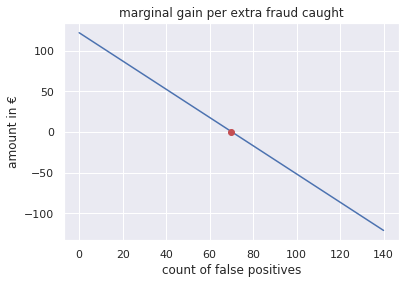

After 70 false positives, it wasn't worth catching the extra fraud.


In [9]:
# visualising the marginal cost function
count_of_false_positives = np.arange(0, avg_fraud_cost / avg_monitoring_cost * 2)
marginal_cost_function = count_of_false_positives * -avg_monitoring_cost + avg_fraud_cost
intersect = int(avg_fraud_cost / avg_monitoring_cost)

plt.title('marginal gain per extra fraud caught')
plt.ylabel('amount in €')
plt.xlabel('count of false positives')
plt.plot(marginal_cost_function)
plt.plot(intersect, 0, 'ro')
plt.show();

print(f'After {intersect} false positives, it wasn\'t worth catching the extra fraud.')

# Cost of doing nothing

In [10]:
fraud = len(df.loc[df.label == 1])
print(f'Reimbursing all fraud would on average cost ~ € {round(fraud/2 * avg_fraud_cost,1):,} / day')

Reimbursing all fraud would on average cost ~ € 30,061.2 / day


# Baseline Model
Let's blindly apply a logistic regression model for us as a benchmark for future iterations. <br>
We should be able to get away with this reasonably well, since the dataset has been preprocessed already (anonymised through PCA, it seems).

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
# splitting our label classification from our dataset and dropping redundant columns
features = df.drop(['time', 'amount', 'label'], axis=1)
labels = df.label
column_names = list(features.columns)

X_train, X_test, y_train, y_test = train_test_split(
    features.values, 
    labels.values,
    shuffle=True,
    stratify=labels.values,
    test_size=TEST_RATIO,
    random_state=RANDOM_SEED
) 

In [13]:
# Bundling the costs in a dictionary for use in our functions
costs = {
    'avg_fraud_cost': avg_fraud_cost,
    'avg_monitoring_cost': avg_monitoring_cost,
    'test_ratio': TEST_RATIO
}    

def cost_function(fp, fn, costs):
    return fp * costs['avg_monitoring_cost'] + fn * costs['avg_fraud_cost']

def misclassification_cost(classification_matrix, costs):
    false_negatives = classification_matrix[1,0]
    false_positives = classification_matrix[0,1]

    cost = cost_function(fp=false_positives, fn=false_negatives, costs=costs)
    
    validation_cost = f'\nThe misclassification cost on this validation set \
({TEST_RATIO * 100}% of data) is € {cost:,.2f}'
    estimation_cost = f'\nExtrapolated to an entire day\'s worth of transactions \
(/{TEST_RATIO}/2 days), we get ~ € {cost/TEST_RATIO/2:,.2f}'
    
    return validation_cost + estimation_cost

def evaluation_report(ground_truth, predicted, costs):
    report = classification_report(ground_truth, predicted)
    conf_matrix = confusion_matrix(ground_truth, predicted)
    cost = misclassification_cost(conf_matrix, costs)
    
    return f'{report}\n{conf_matrix}\n{cost}'

### Reading a confusion matrix
To keep this already lengthy notebook a bit more comptact, we'll be printing out the confusion matrices.
That means they'll be unlabeled, though, so here's a quick refresher.
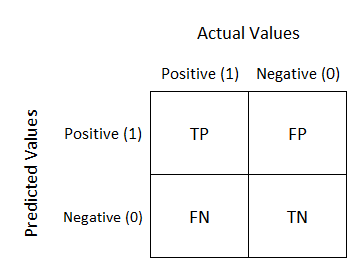

In [14]:
# lbfgs will be the new default solver
# specified as argument to supress warning message
Lr = LogisticRegression(solver='lbfgs') 

# fit & Predict
Lr.fit(X_train, y_train)
y_pred = Lr.predict(X_test)

# evaluate our model
print(evaluation_report(y_test, y_pred, costs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.53      0.67        98

    accuracy                           1.00     56962
   macro avg       0.96      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962

[[56859     5]
 [   46    52]]

The misclassification cost on this validation set (20.0% of data) is € 5,629.89
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 14,074.71


It's already much better than doing nothing... but recall really isn't great at this point. Of course, we haven't set up the model to prioritise it.
We can attribute different weights to the classes to solve for this.

>https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html    
>The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). <br>


In [15]:
# instantiate regressor
Lr = LogisticRegression(solver='lbfgs', class_weight='balanced')

# fit & Predict
Lr.fit(X_train, y_train)
y_pred = Lr.predict(X_test)

# evaluate our model
print(evaluation_report(y_test, y_pred, costs))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.96      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.97      0.55     56962
weighted avg       1.00      0.98      0.99     56962

[[55501  1363]
 [    4    94]]

The misclassification cost on this validation set (20.0% of data) is € 2,856.47
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 7,141.17


Better recall, as we're catching more fraud, but we're losing out on the surplus due to a slew of transactions we now have to investigate.

## Custom class weight
Let's apply the same method, but pass onto the model the cost ratio we have calculated prior.

In [16]:
# custom weight
fraud_weight = round(avg_fraud_cost / avg_monitoring_cost, 1)
print(f'The weight we\'ve attributed to fraud is: {fraud_weight} to 1\n')

# instantiate regressor
Lr_Weight = LogisticRegression(solver='lbfgs', class_weight={
    1: fraud_weight,
    0: 1
})

# fit & Predict
Lr_Weight.fit(X_train, y_train)
y_pred = Lr_Weight.predict(X_test)

# evaluate our model
print(evaluation_report(y_test, y_pred, costs))

The weight we've attributed to fraud is: 70.3 to 1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.45      0.90      0.60        98

    accuracy                           1.00     56962
   macro avg       0.72      0.95      0.80     56962
weighted avg       1.00      1.00      1.00     56962

[[56756   108]
 [   10    88]]

The misclassification cost on this validation set (20.0% of data) is € 1,409.61
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 3,524.02


Clearly, this solves our cost function much better. We have reduced the costs associated with fraud detection by almost an order of magnitude.

Although we have a couple of extra cases of fraud slipping through, we make up for it by saving tremendously on monitoring costs.

**It's now up to us to improve the model** across the board. 

# SMOTE

The *Synthetic Minority Oversampling TEchnique* is a promising way to feed the model more fraud data, albeit synthetically. <br>
A great blog post on the topic: http://rikunert.com/SMOTE_explained

In [17]:
def plot_data(X, y, title='', name="graph.png"):
    plt.figure(figsize=(16,8));
    
    # clean
    plt.scatter(
        X[y == 0, 12], X[y == 0, 11], 
        label='clean', 
        alpha=0.2, 
        linewidth=0.05, 
        color='#9db68c' # green
    );
    
    # fraud
    plt.scatter(
        X[y == 1, 12], X[y == 1, 11],
        label='fraud',
        alpha=0.5,
        linewidth=0.05, 
        color='#db5e5e' # red
    );
    
    plt.title(title);
    plt.legend(loc='best');
    plt.savefig(name);

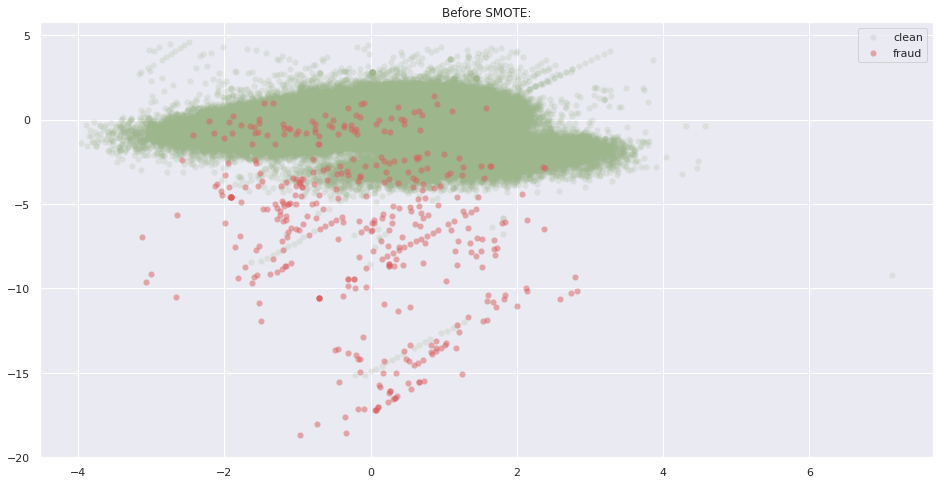

In [18]:
plot_data(X_train, y_train,
          title='Before SMOTE:',
          name='before_smote.png')

### Avoid data leakage
Note that we **resample only the training set**, so as to avoid leaking test data to the new model trained on the oversampled set.
After all, **oversampling changes the shape of the dataset, so future train_test_split() wouldn't produce the same distinctly isolated sets**, even with the same random_state parameter. We definitely want to avoid training on data we then test on.

In [19]:
fraud_in_train_set = y_train.sum()
print(f'There are {fraud_in_train_set} fraud transactions in the training set')

There are 394 fraud transactions in the training set


In [20]:
from imblearn.over_sampling import SMOTE

# Define the resampling method
resampler = SMOTE(
    random_state=RANDOM_SEED,
    
    # synthetically create a multiple of fraud observations currently in the training set
    sampling_strategy={1: int(fraud_in_train_set * fraud_weight)}
)

# Create the resampled feature set
X_train_resampled, y_train_resampled = resampler.fit_sample(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [21]:
print(f'There are now {y_train_resampled.sum():,} fraud transactions in the oversampled training set')

There are now 27,698 fraud transactions in the oversampled training set


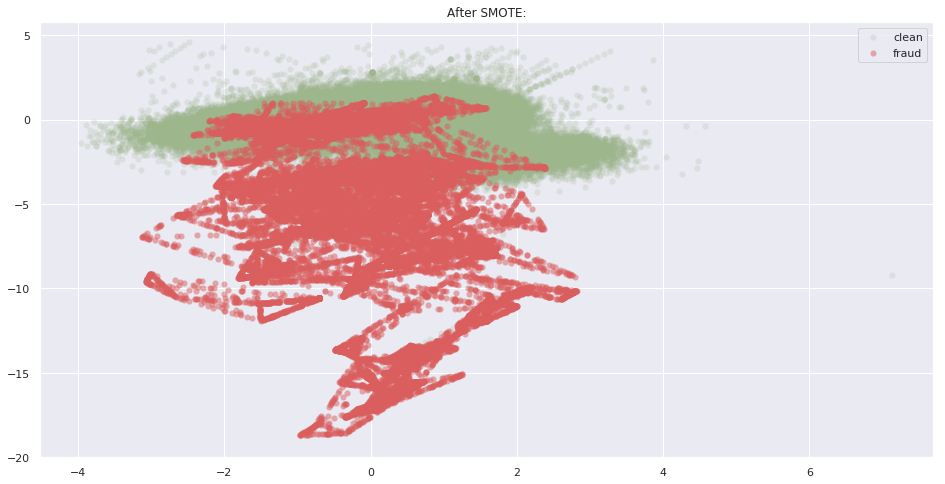

In [22]:
plot_data(X_train_resampled, y_train_resampled,
          title='After SMOTE:',
          name='after_smote.png')

# Effect of SMOTE on performance

In [23]:
# instantiating & training
Lr = LogisticRegression(solver='lbfgs')
Lr.fit(X_train_resampled, y_train_resampled)

# predict on our previous test-set so we have comparable results
y_pred = Lr.predict(X_test)

# evaluate our model
print(evaluation_report(y_test, y_pred, costs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.91      0.58        98

    accuracy                           1.00     56962
   macro avg       0.71      0.95      0.79     56962
weighted avg       1.00      1.00      1.00     56962

[[56744   120]
 [    9    89]]

The misclassification cost on this validation set (20.0% of data) is € 1,308.25
Extrapolated to an entire day's worth of transactions (/0.2/2 days), we get ~ € 3,270.63


The results are similar. We shouldn't be overly surprised by this, of course. After all, **SMOTE was configured to multiply the amount of fraud samples we already had by the fraud_weight we had found as a result of our cost comparison**.

It does seem that **SMOTE slightly outperforms a simple configuration of the LogisticRegression's class_weight parameter when it comes to catching fraud**. The synthetic imputation allowed our model to generalize just a little bit better than simply training on the same data points over a multiple of iterations. We would have to cross-validate to check this.

# Finetuning Thresholds
To further improve, we can look at the computed class probabilities of a classifier and shift the threshold at which we deem a case to be fraud. This allows us to further tune the cost-efficiency of our model.

In [24]:
def cost_per_threshold(sklearn_classifier, X, y, costs):
    """ return four lists:
            1) list of thresholds (defined in this function) 
            2) count of false negatives (uncaught fraud)
            3) count of false positives (overreported transactions)
            4) total cost per threshold iteration
    """
    
    # shorter variable
    clf = sklearn_classifier
    
    # lists to be passed to plot
    thresholds = np.arange(start=0.05, stop=1, step=0.025)
    fn, fp = [], []

    # looping through thresholds to plot cost curve
    for threshold in thresholds:

        # custom threshold
        y_pred = (clf.predict_proba(X)[:,1] > threshold).astype(int)

        # extracting performance indicators
        false_positives = confusion_matrix(y, y_pred)[0,1]
        false_negatives = confusion_matrix(y, y_pred)[1,0]

        # add to lists
        fp.append(false_positives)
        fn.append(false_negatives)

    # convert to numpy arrays
    fp = np.asarray(fp)
    fn = np.asarray(fn)
    c = cost_function(fp, fn, costs)
    
    # return values
    return thresholds, fp, fn, c

In [25]:
def plot_misclassification(thresholds, fp, fn, c):
    
    # two y-axes sharing the same plot
    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    """ LEFT PLOT """
    left.title.set_text('Misclassification Counts')

    # 1st y-axis
    color = 'tab:orange'
    left.set_xlabel('threshold')
    left.set_ylabel('false positives', color=color)
    left.plot(thresholds, fp, color=color)
    left.tick_params(axis='y', labelcolor=color)

    # 2nd y-axis
    left_2nd_y = left.twinx() # share the same x-axis
    color = 'tab:red'
    left_2nd_y.set_ylabel('false negatives', color=color) 
    left_2nd_y.plot(thresholds, fn, color=color)
    left_2nd_y.tick_params(axis='y', labelcolor=color)


    """ RIGHT PLOT """
    right .title.set_text('Misclassification Costs')

    # plotting costs
    color = 'tab:blue'
    right.set_xlabel('threshold')
    right.set_ylabel('total (€)', color=color)
    right.plot(thresholds, c, color=color)
    right.tick_params(axis='y', labelcolor=color)

    
    """ ANNOTATE """
    # calculate minimum cost threshold
    optimal_threshold = min(zip(thresholds, c), key=lambda t: t[1])
    optimal_threshold_index = np.where(thresholds==optimal_threshold[0])[0] 
    optimal_threshold_fp = fp[optimal_threshold_index]
    optimal_threshold_fn = fn[optimal_threshold_index]
    
    right.plot(*optimal_threshold, 'go');
    
    # display cost optimum
    print(f'The cost minimum occurs at threshold {optimal_threshold[0]:.3f}, where the misclassification are as follows')
    print(f'    False positives: {optimal_threshold_fp}')
    print(f'    False negatives: {optimal_threshold_fn}')
    print('')
    print(f'Misclassification costs on test sample: {optimal_threshold[1]:,.2f}')
    print(f'Extrapolated daily cost: {optimal_threshold[1]/TEST_RATIO/2:,.2f}')
    
    """ DISPLAY """
    # prevent clipping and overlap between graphs
    fig.tight_layout()  
    plt.show();

The cost minimum occurs at threshold 0.425, where the misclassification are as follows
    False positives: [169]
    False negatives: [8]

Misclassification costs on test sample: 1,271.17
Extrapolated daily cost: 3,177.92


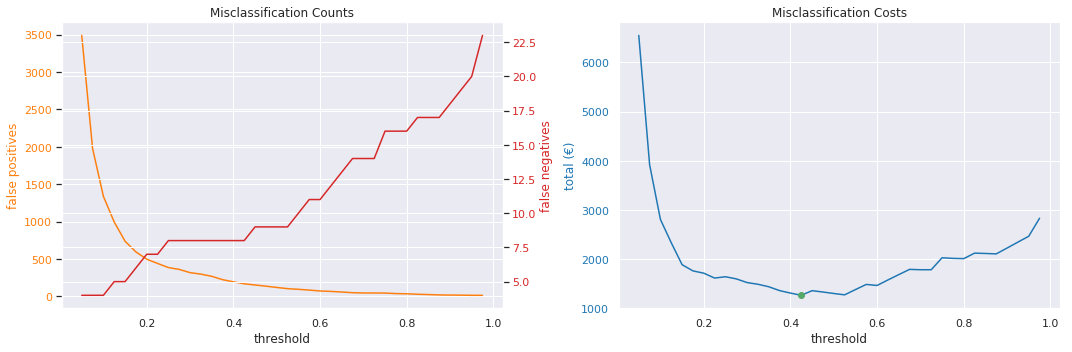

In [26]:
# compute results at each threshold level
thresholds, fp, fn, c = cost_per_threshold(Lr, X_test, y_test, costs)

# visualise them
plot_misclassification(thresholds, fp, fn, c)

# Conclusion

The purpose of this notebook is twofold:

1. highlight the fact that **choosing the right performance metric** is important when 
    * **classes are unbalanced** 
    * the **consequences of misclassification (type I & II) are asymmetrical**
    
    
2. to show that **machine learning algorithms can be highly effective at calibrating the rate of false negatives vs false positives, thereby optimizing a cost function** - more so than rule-based systems.

If you found this kernel helpful, or appreciated the alternative angle of approaching this dataset from a business perspective, please upvote it.
